In [1]:
import copy
import csv
import cvxpy
import datetime
import json
import math
import matplotlib.pyplot as plt
import multiprocessing
from multiprocessing import Pool
import numpy as np
import os
import pandas as pd
import pickle
import random
import seaborn as sns
from typing import List, Dict
import sys
sys.path.append('../')

from skyburst import Job
from skyburst.plot import *
from skyburst.traces import philly
from skyburst.traces import philly_utils
from skyburst import job_gen
from skyburst.simulator import run_simulator

run_config = {
    # Size of the cluster (i.e. # of cluster nodes).
    'cluster_size': 4,
    # Number of GPU(s) per cluster node.
    'gpus_per_node': 8,
    # Number of CPU(s) per cluster node.
    'cpus_per_node': 48,
    # Scheduling algorithm specifying order of the queue.
    'sched_alg': 'fifo',
    # How jobs are binpacked into the cluster.
    'binpack_alg': 'best-fit',
    # Waiting policy (how long jobs should wait in the cloud).
    'waiting_policy': 'linear_runtime',
    # Waiting hyperparameter (to be passed to waiting_policy)
    'waiting_factor': 1.25,
    # Sets clipping time for waiting (max time a job should wait)
    'clip_time': 1e9,
    # Enable backfill (assumes time estimator).
    'backfill': False,
    # Enable loop scheduling (just loop through entire queue, remove HoL).
    'loop': False,
    # Enable prediction. (Jobs predict if they can be assigned to cluster before timing out).
    # 0 is no prediction, 1 is perfect oracle
    'predict_wait': 0,
    # Queue length
    'max_queue_length': -1,
    # Time estimator error
    'time_estimator_error': 0,
    # (Deprecated) Algorithm to immediately send job to cloud (without waiting).
    'filter_alg': None,
    # Prints out simulator state at every timestep.
    'verbose': False,
    # Appends python debugger at every timestemp.
    'debug': False,
    # Position for TQDM progress tracker bar.
    'pbar_idx': 0,
    # Jobs to not consider for final metrics at the beg. and end. of simulator.
    'warmup_jobs': 5,
    # Whether to get snapshots and save to result dict
    'snapshot': False,
    # Metadata on job generation (run prior to simulator).
    'jobgen_spec': {
        # Dataset type ['philly', 'philly_gen', 'gen_gpu']
        'dataset': '',
        # Arrival rate of jobs (used in 'gen_gpu', 'philly_gen')
        'arrival_rate': -1,
        # Total number of jobs generated.
        'total_jobs': -1,
        # Avg. Job runtime (used in 'gen_gpu')
        'job_runtime': -1,
    }
}
from skyburst.traces import philly
#philly_jobs = philly.load_philly_traces('~/philly-traces/trace-data')
# jobs_100 = job_gen.generate_philly_gpu_jobs(philly_jobs, 24, total_jobs=200, seed=78493729)

jobs_100 = job_gen.generate_synthetic_jobs(arrival_rate=15, total_jobs=500, seed=np.random.seed())


Jobs progress: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 24541.58it/s]


Sched Policy    Waiting Policy      # Cluster Nodes    Total Cloud Cost    Avg. Cloud Cost    Avg. Waiting    Avg. JCT    Cluster Utilization    System Utilization
--------------  ----------------  -----------------  ------------------  -----------------  --------------  ----------  ---------------------  --------------------
fifo            zero-1                            4             231.997            7.81518     2.26115e-19     1.02175               0.711293              0.955517


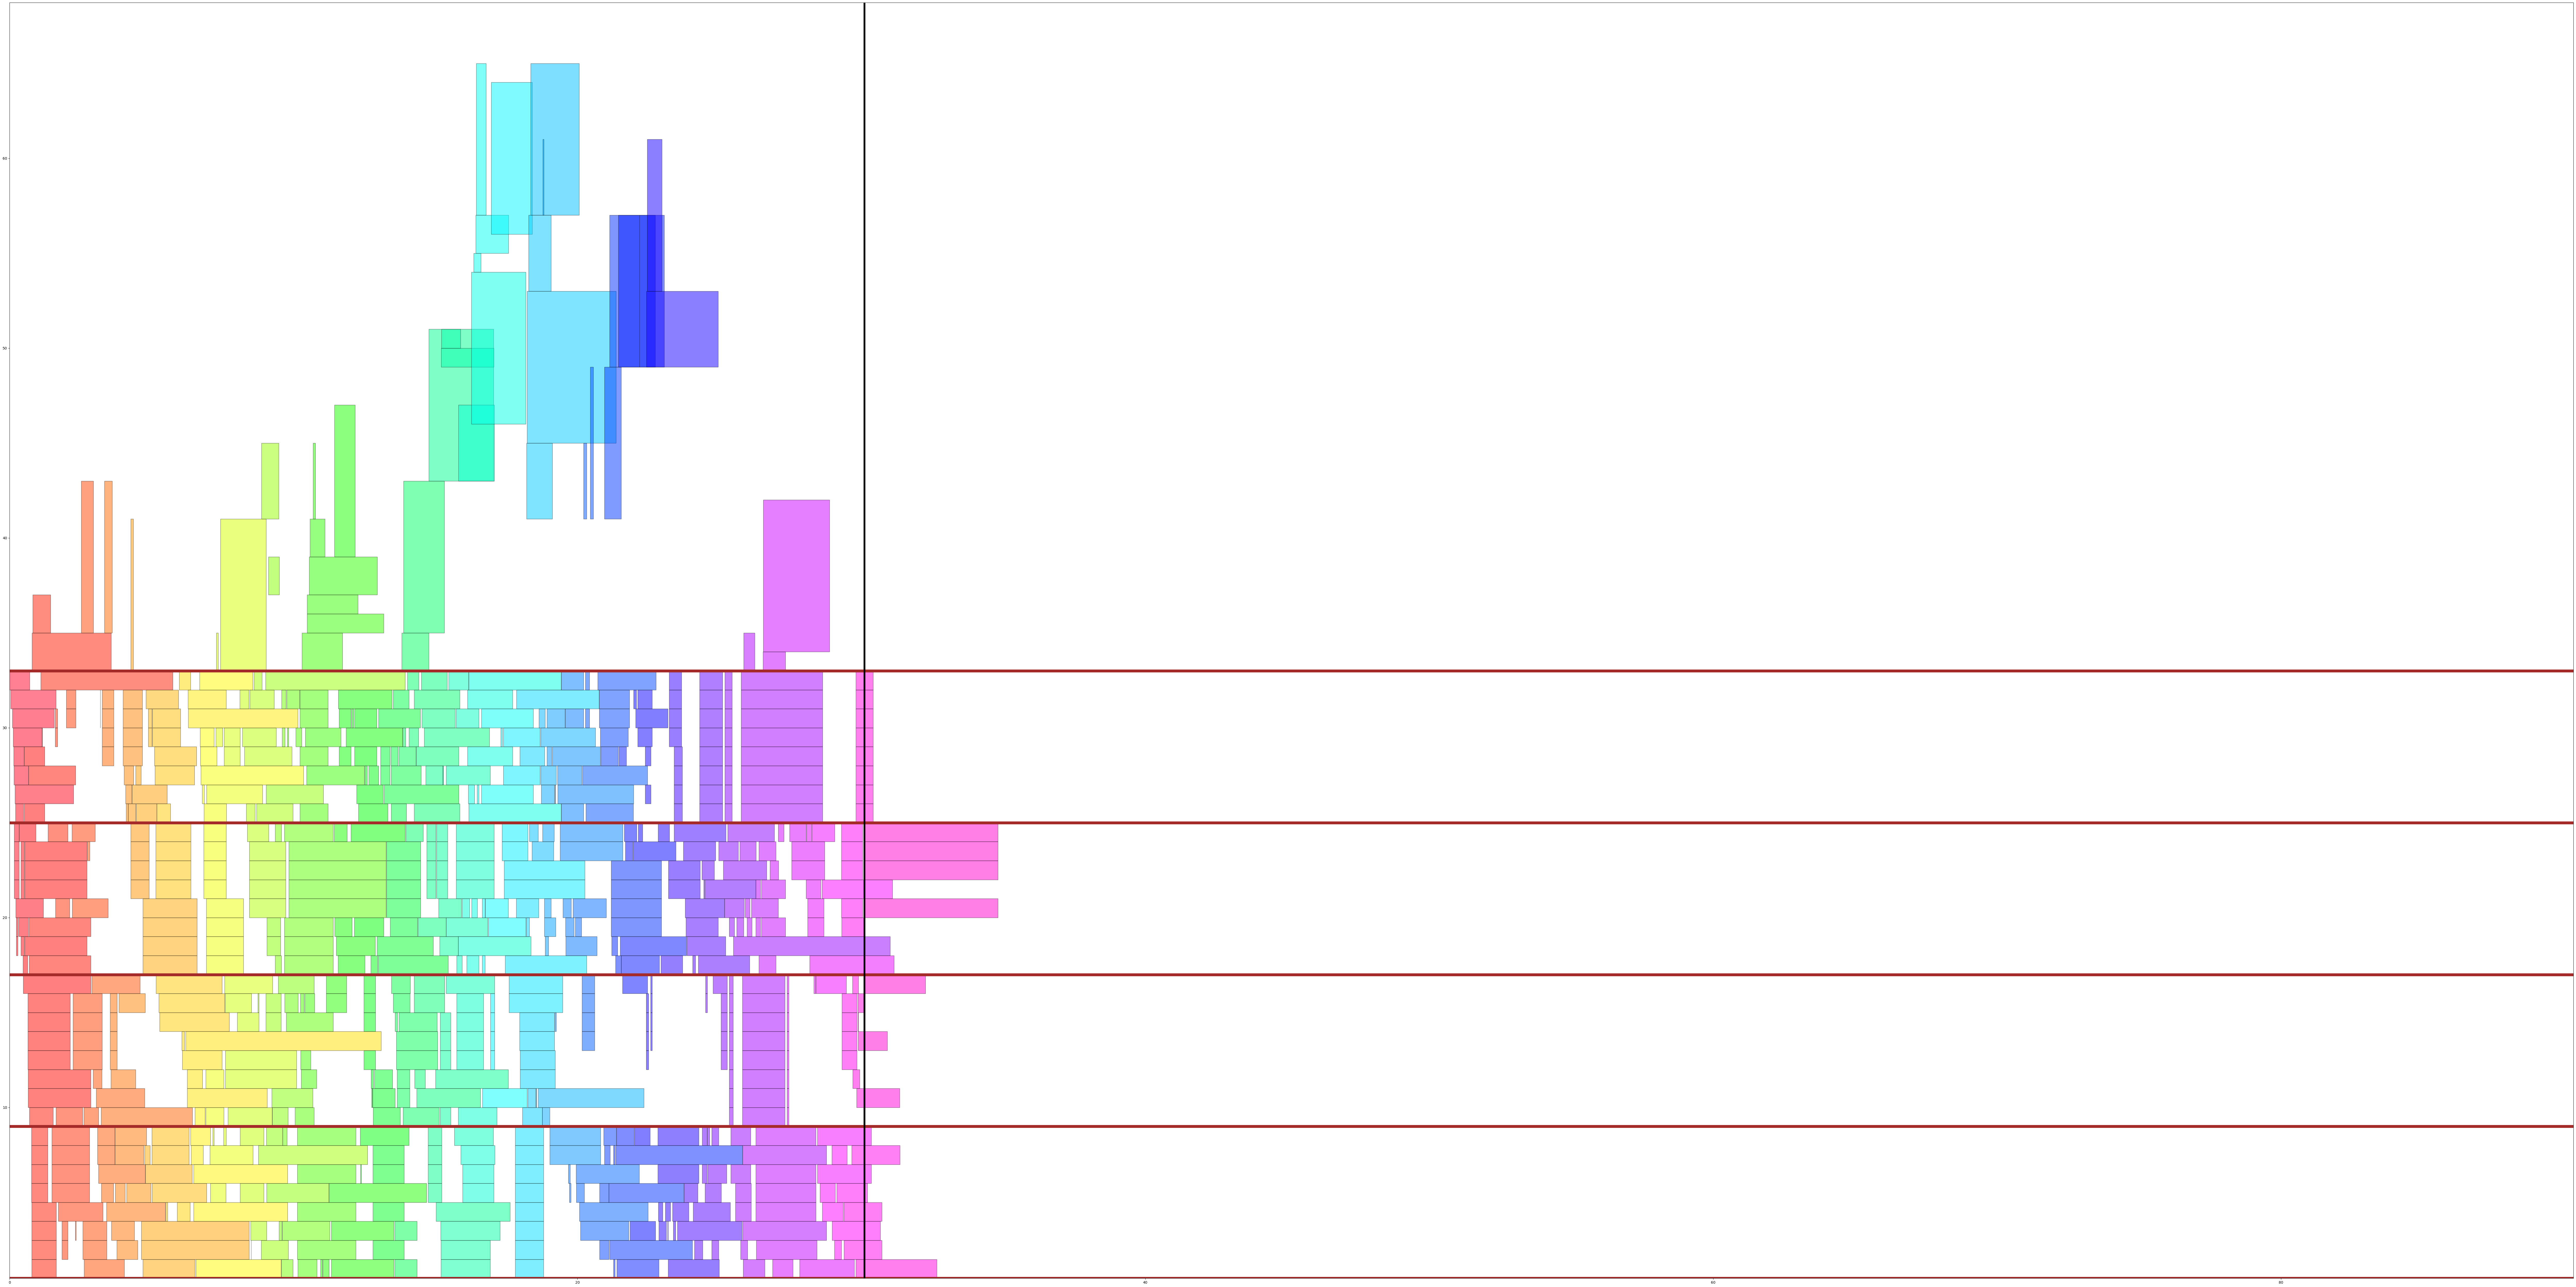

In [2]:
run_config['waiting_policy'] = 'zero'
run_config['waiting_factor'] =  1
run_config['loop'] =0

asdf = run_simulator(jobs_100, run_config)
plot_trace_spacetime_and_spillover(asdf, 4)

Jobs progress: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 22312.98it/s]


Sched Policy    Waiting Policy                  # Cluster Nodes    Total Cloud Cost    Avg. Cloud Cost    Avg. Waiting    Avg. JCT    Cluster Utilization    System Utilization
--------------  ----------------------------  -----------------  ------------------  -----------------  --------------  ----------  ---------------------  --------------------
fifo            constant-0.25737121611539954                  4             202.291            6.81449       0.0447366     1.06649               0.742564              0.955517
118.13338819696912


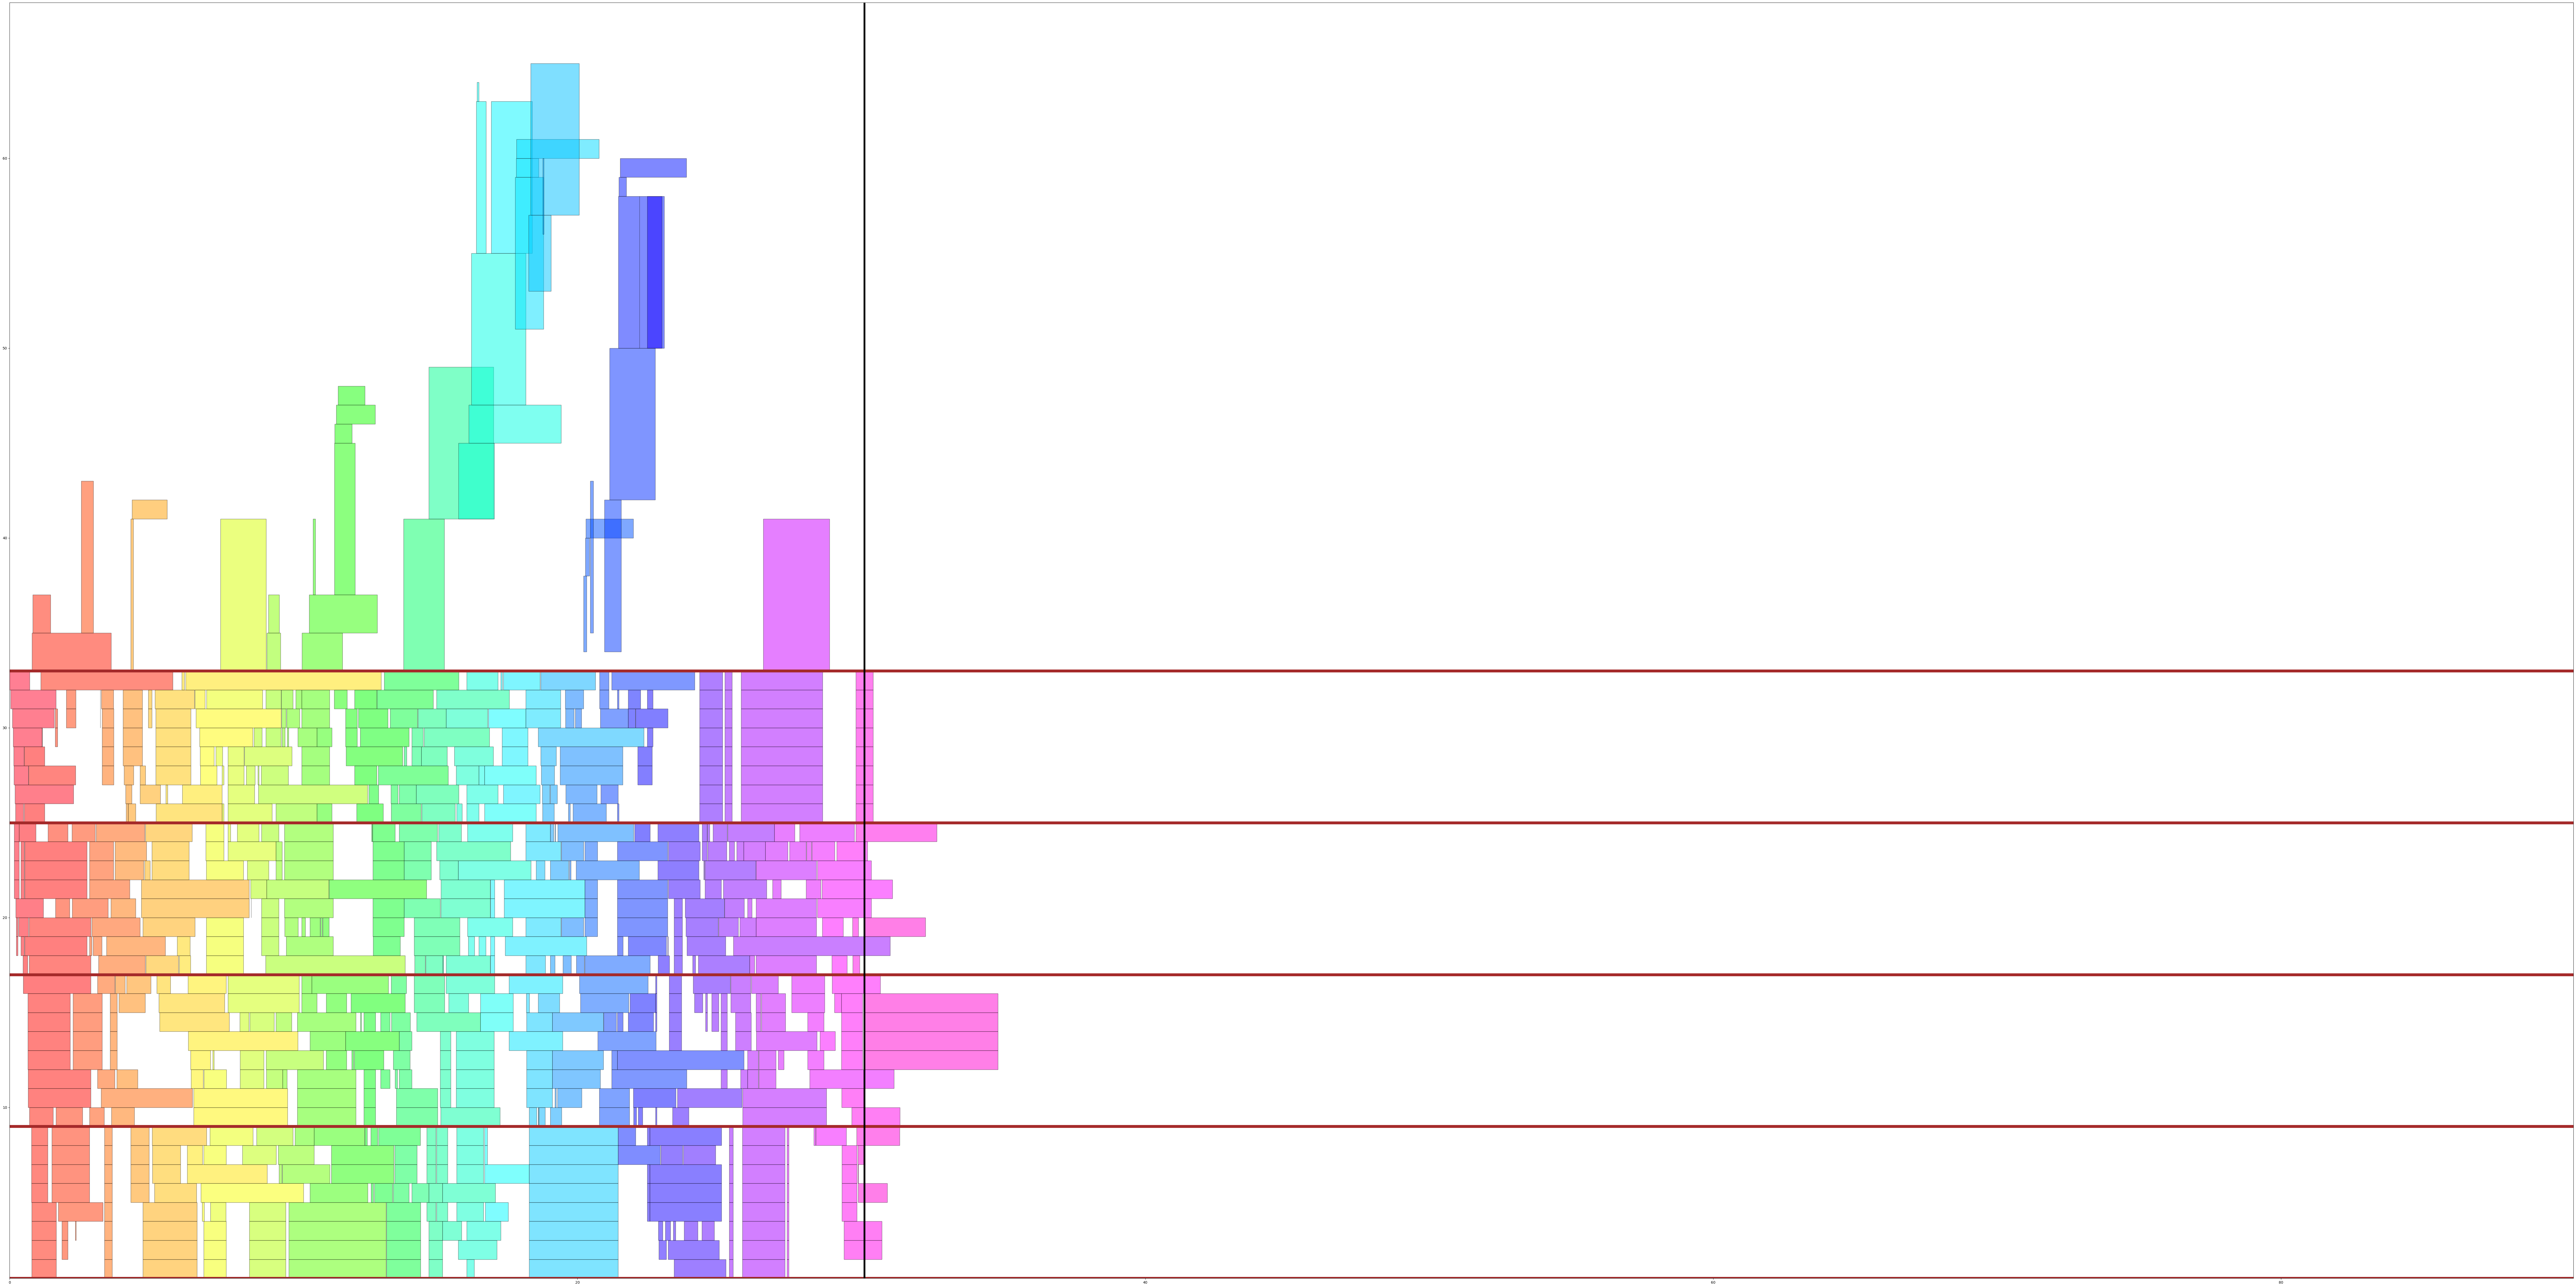

In [3]:
run_config['waiting_policy'] = 'constant'
constant_factor =  np.mean([j.runtime for j in jobs_100])/4
run_config['waiting_factor'] =  constant_factor
run_config['loop'] = 0

asdf = run_simulator(jobs_100, run_config)

total_wait = 0
for i in range(len(asdf['idx'])):
    if asdf['state'][i] == 'LOCAL':
        total_wait += asdf['deadline'][i] - asdf['runtime'][i] - asdf['arrival'][i]
print(total_wait)
plot_trace_spacetime_and_spillover(asdf, 4)

Jobs progress: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 17987.87it/s]


Sched Policy    Waiting Policy      # Cluster Nodes    Total Cloud Cost    Avg. Cloud Cost    Avg. Waiting    Avg. JCT    Cluster Utilization    System Utilization
--------------  ----------------  -----------------  ------------------  -----------------  --------------  ----------  ---------------------  --------------------
fifo            linear_cost-0.12                  4             137.948              4.647       0.0466533      1.0684               0.810298              0.955517


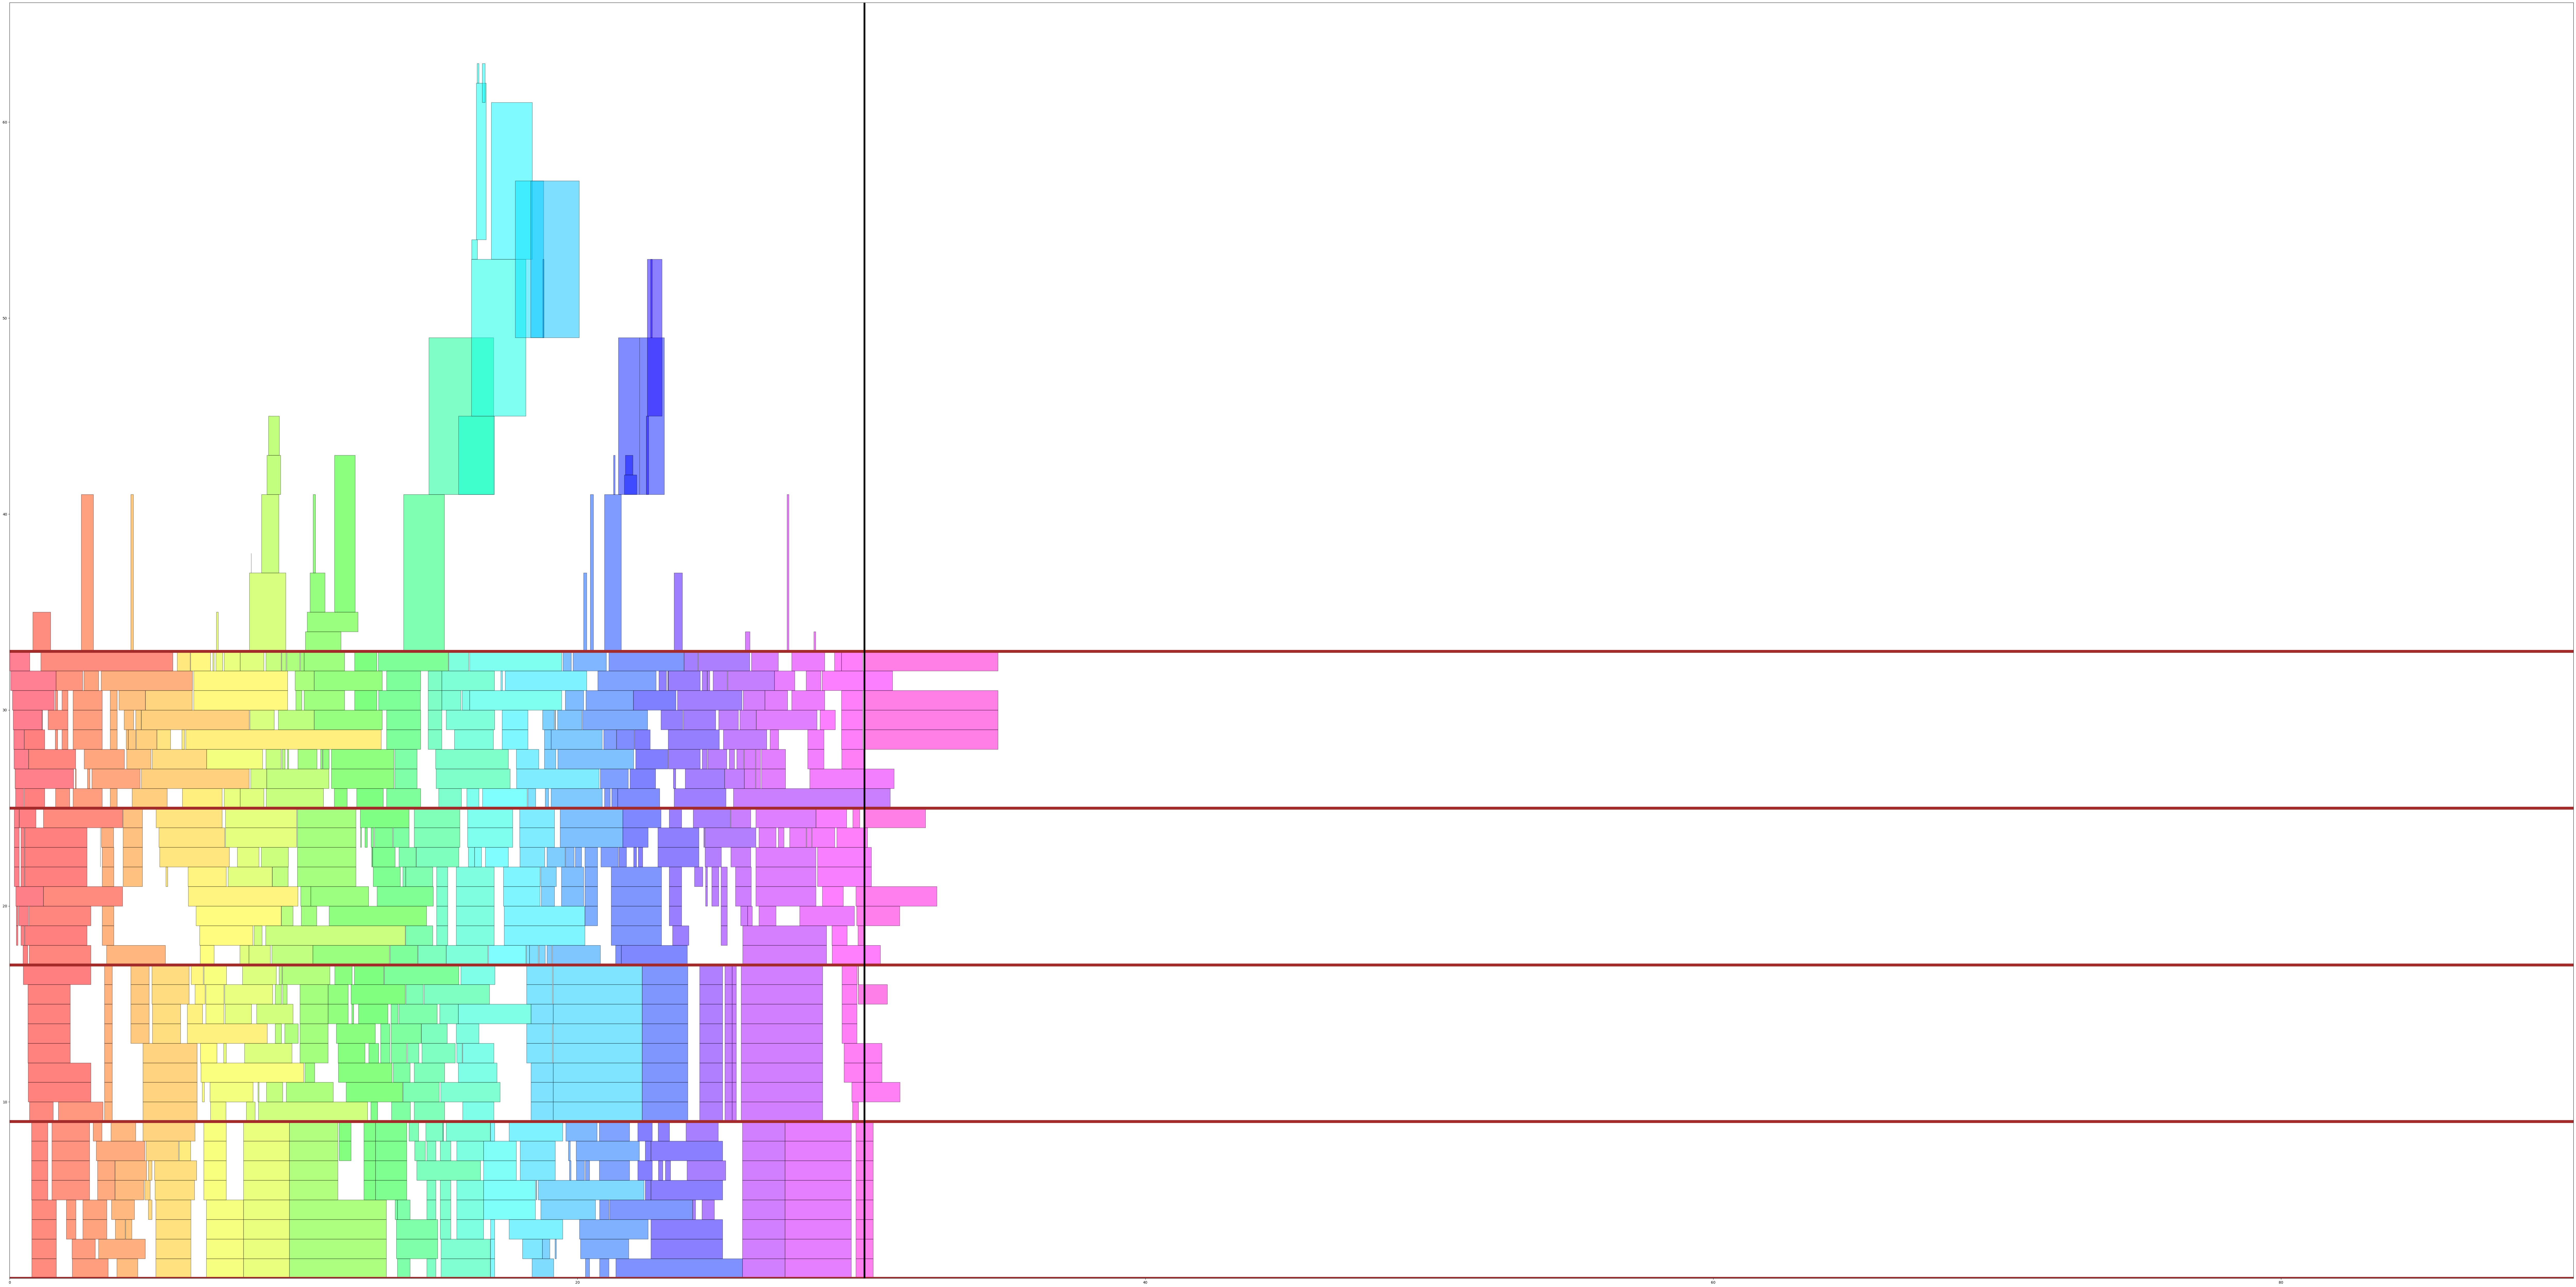

97.4293464471563


In [17]:
run_config['waiting_policy'] = 'linear_cost'
run_config['waiting_factor'] =  0.12
run_config['loop'] = 1
asdf1 = run_simulator(jobs_100, run_config)
plot_trace_spacetime_and_spillover(asdf1, 4)

total_wait = 0
for i in range(len(asdf1['idx'])):
    if asdf1['state'][i] == 'LOCAL':
        total_wait += asdf1['deadline'][i] - asdf1['runtime'][i] - asdf1['arrival'][i]
print(total_wait)

In [18]:
def milp_solver_v3(jobs: List[Job], nodes, prefill=None):
    import cvxpy
    import numpy as np
    bin_width = 8
    bin_height = 1e6
    num_jobs = len(jobs)
    arrivals = np.array([j.arrival for j in jobs])
    runtimes = np.array([j.runtime for j in jobs])
    
    avg_runtime = np.mean(runtimes)
    wait_time_limit = 0.0447366 * len(jobs) #0.25 * avg_runtime * num_jobs
    # Want to maximize cluster utilziation here
    arrival_start = arrivals[5]
    arrival_end = arrivals[95]
    
    #deadlines = np.array([j.deadline for j in jobs])
    
    num_gpus = []
    num_nodes = []
    costs = []
    for j in jobs:
        gpus = j.num_gpus
        if gpus > bin_width:
            assert gpus % bin_width == 0
            num_nodes.append(int(gpus/bin_width))
            num_gpus.append(bin_width)
            costs.append(j.cost/int(gpus/bin_width))
        else:
            num_nodes.append(1)
            num_gpus.append(gpus)
            costs.append(j.cost)
    
    num_gpus = np.array(num_gpus)
    num_nodes = np.array(num_nodes)
    costs = np.array(costs).reshape((num_jobs, 1))
    
    
    
    left = cvxpy.Variable((num_jobs, num_jobs), boolean=True)
    bottom = cvxpy.Variable((num_jobs, num_jobs), boolean=True)
    selection =  cvxpy.Variable((nodes, num_jobs), boolean=True)
    x_w = cvxpy.Variable((num_jobs,), integer=True)
    y_h = cvxpy.Variable((num_jobs,))
    wait_times = cvxpy.Variable((num_jobs,))
    all_or_nothing = cvxpy.Variable((num_jobs,), boolean=True)
    
    constraints = []
    
    # Restriction on X,Y coordinates
    constraints.append(x_w >= 0)
    constraints.append(x_w <= bin_width - num_gpus)
    constraints.append(y_h >= arrivals)
    constraints.append(y_h <=arrivals + wait_times)
    constraints.append(cvxpy.sum(wait_times) <= wait_time_limit)
    # Restriction on selection
    constraints.append(cvxpy.sum(selection, axis=0) == cvxpy.multiply(num_nodes, all_or_nothing))
    
    # Restriction on Boxes not intersecting
    triangle_filter = 100*np.triu(np.ones((num_jobs, num_jobs)))
    var_filter = triangle_filter + left + left.T + bottom + bottom.T 

    # Add constraints for each node boxes
    for n_idx in range(nodes):
        row = selection[n_idx]
        outer_sum = cvxpy.reshape(row, (num_jobs, 1)) + cvxpy.reshape(row, (1, num_jobs))
        constraints.append(var_filter + (2 - outer_sum) >=1)

    eq_1 = cvxpy.reshape(x_w + num_gpus, (num_jobs, 1)) - cvxpy.reshape(x_w, (1, num_jobs)) + bin_width * left <= bin_width 
    eq_2 = cvxpy.reshape(y_h + runtimes, (num_jobs, 1)) - cvxpy.reshape(y_h, (1, num_jobs)) + bin_height * bottom <= bin_height
    constraints.append(eq_1)
    constraints.append(eq_2)

    import gurobipy
    env = gurobipy.Env()
    env.setParam('TimeLimit', 3600) # in seconds
    
    total_utility = cvxpy.sum(selection@costs)
    #total_utility = cvxpy.sum(total_utility)
    super_problem = cvxpy.Problem(cvxpy.Maximize(total_utility), constraints)

    # Solving the problem
    #opts = {'limits/time' : 1200, 'parallel/minnthreads': 32, 'parallel/maxnthreads': 63} #{'maxiters' : 5000}
    super_problem.solve(solver=cvxpy.GUROBI, verbose=True, env=env) #scip_params = opts)

    # Restriction on intersections
    return (left, bottom, selection, x_w, y_h, all_or_nothing)

variables  = milp_solver_v3(jobs_100, 4)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2377240
Academic license - for non-commercial use only - registered to michael.luo@berkeley.edu
Set parameter TimeLimit to value 3600
                                     CVXPY                                     
                                     v1.3.0                                    
(CVXPY) May 24 04:32:35 PM: Your problem has 504000 variables, 12 constraints, and 0 parameters.
(CVXPY) May 24 04:32:35 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 24 04:32:35 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 24 04:32:35 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
----------------------

457.95600853703525


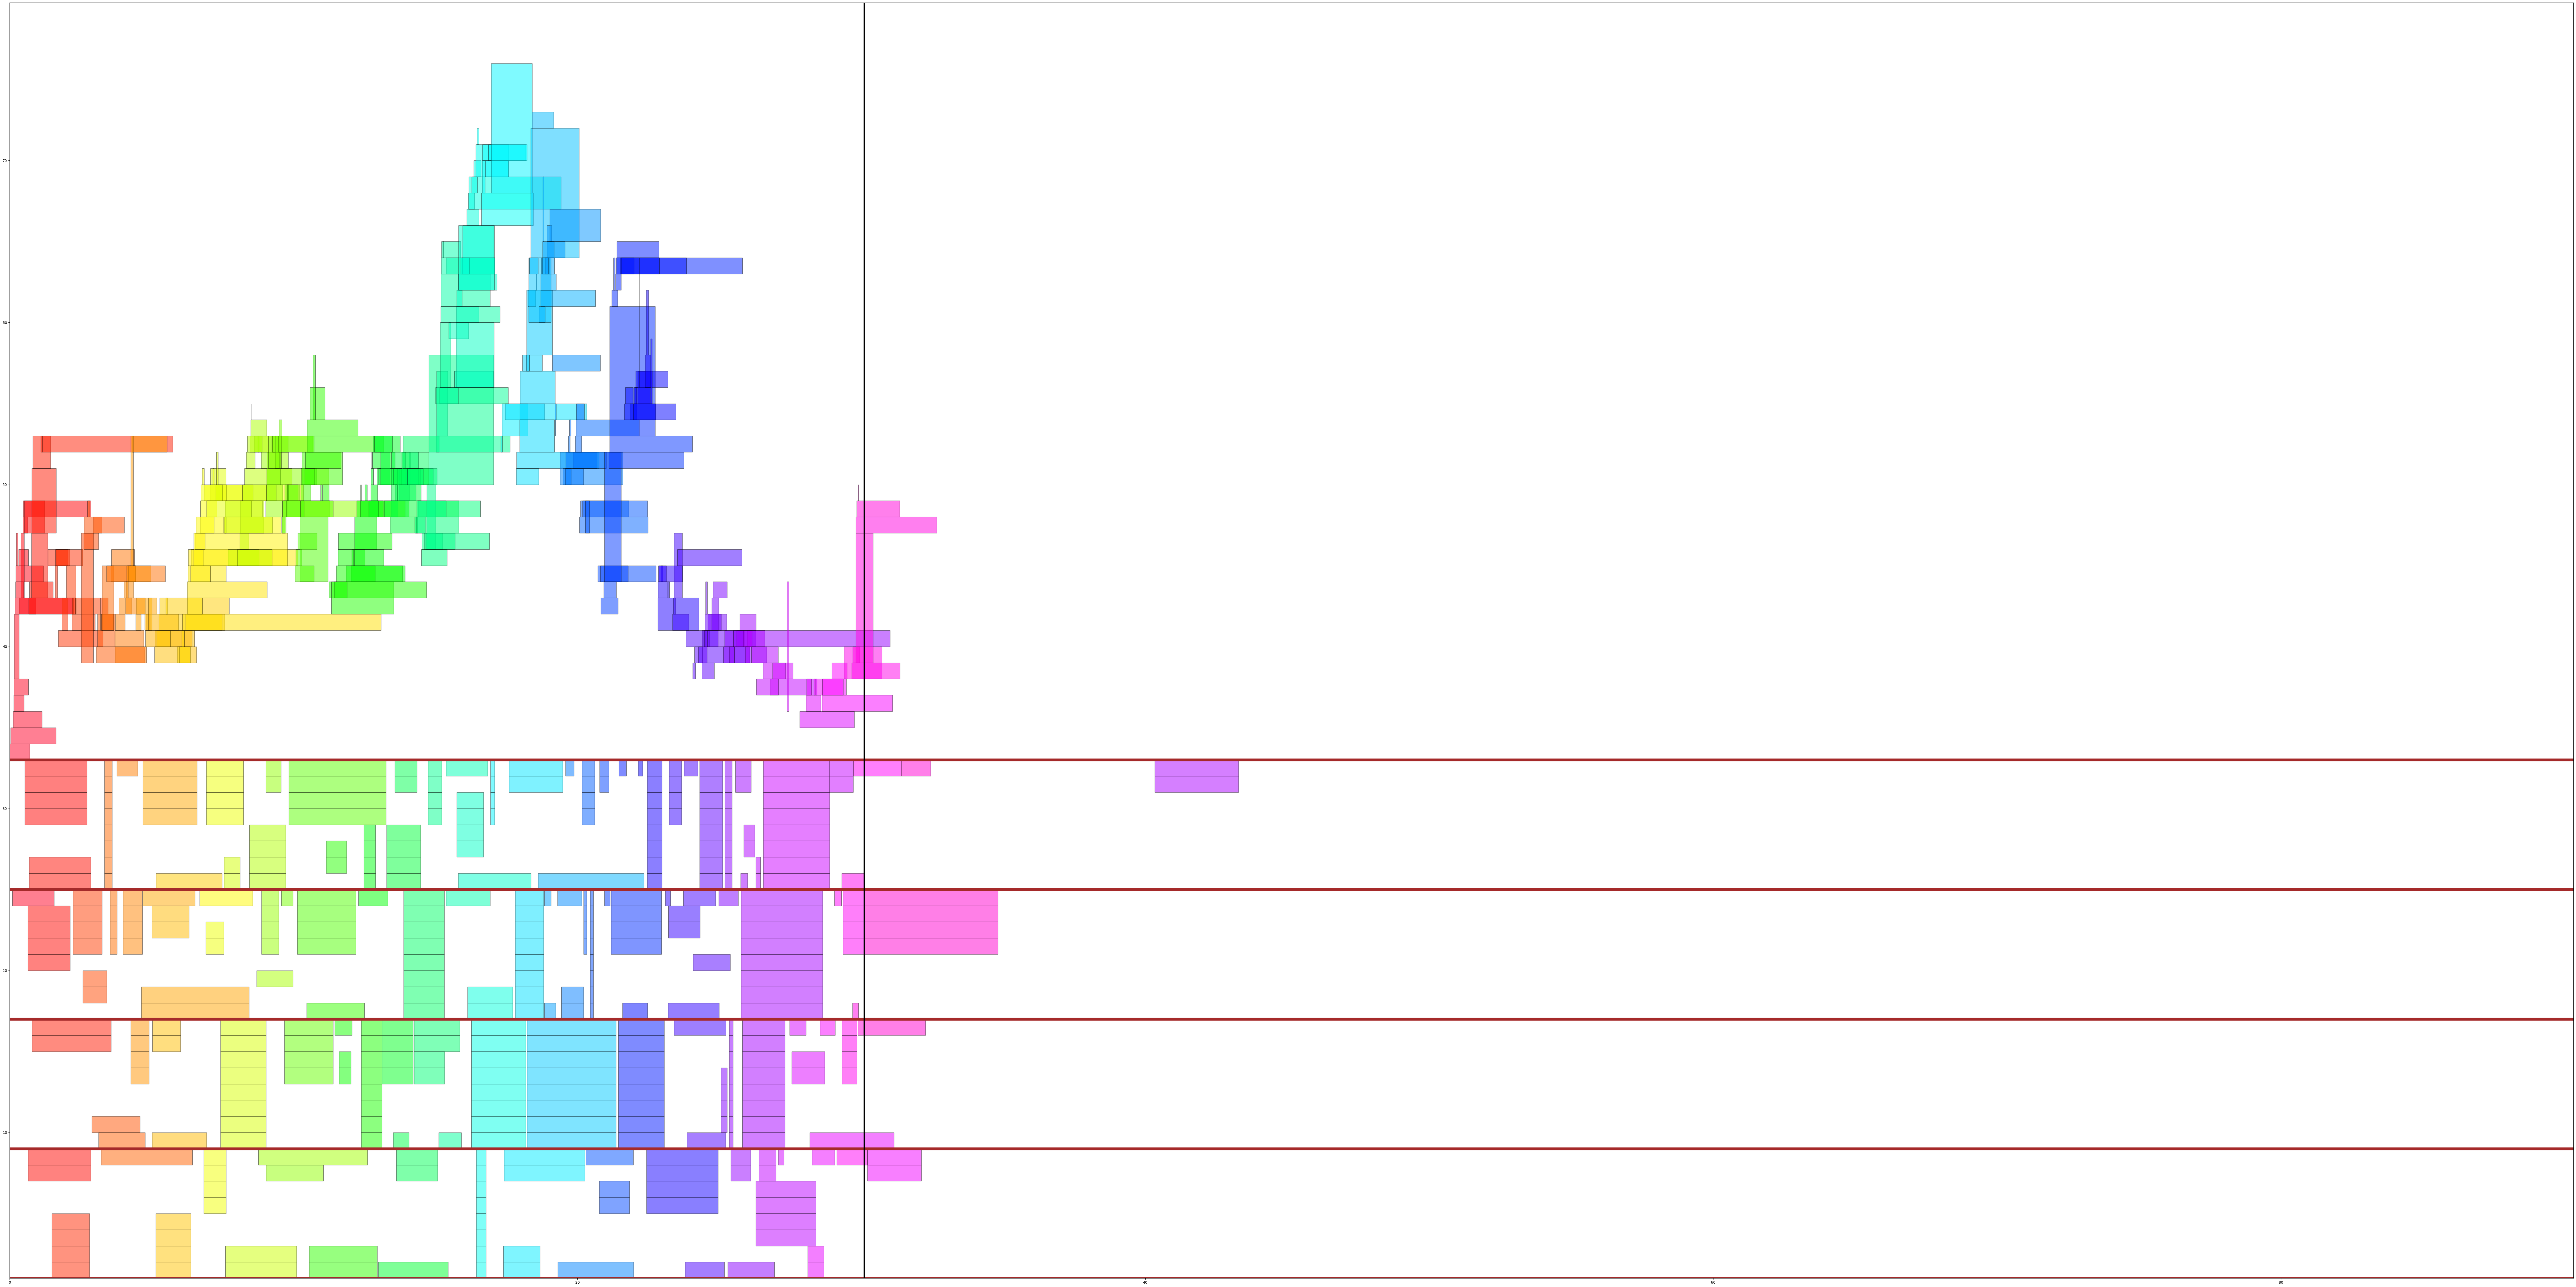

In [19]:
left, bottom, selection, x_w, y_h, all_or_nothing = variables

copy_jobs = copy.deepcopy(jobs_100)
copy_jobs.sort(key=lambda x: x.idx)

gpu_values = selection.value
summed_values = np.sum(gpu_values, axis=0)
cloud_cost = 0
sum_wait =0
for j in copy_jobs:
    idx = j.idx
    if summed_values[idx]==0:
#         if idx < 5 or idx > 95:
#             continue
        cloud_cost += j.cost
        continue
    j.start = y_h.value[idx]
    #print(gpu_values[:,idx])
    for gpu_idx, gpu_v in enumerate(gpu_values[:,idx]):
        if gpu_v ==1:
            j.allocated_gpus[gpu_idx] = list(range(int(x_w.value[idx]), int(x_w.value[idx]) + j.num_gpus))    
    #print(f'{idx} + {j.num_gpus} + {j.allocated_gpus}')
print(cloud_cost)
finished_jobs = copy_jobs
result_dict = {
    'idx': np.array([j.idx for j in finished_jobs]),
    'arrival': np.array([j.arrival for j in finished_jobs]),
    'start': np.array([j.start for j in finished_jobs]),
    'runtime': np.array([j.runtime for j in finished_jobs]),
    'deadline': np.array([j.deadline for j in finished_jobs]),
    'num_gpus': np.array([j.num_gpus for j in finished_jobs]),
    'state': np.array([j.state for j in finished_jobs]),
    'allocated_gpus': np.array([j.allocated_gpus for j in finished_jobs]),
}
plot_trace_spacetime_and_spillover(result_dict, 4)